In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

df = pd.read_csv("../data/yfinance_data2.csv")


In [2]:
stats_close = df.groupby('symbol')['close_price'].describe()

# Đổi tên cột sang tiếng Việt để dễ đưa vào bài luận
stats_close.columns = [
    'Số lượng', 'Trung bình', 'Độ lệch chuẩn', 
    'Tối thiểu', '25%', 'Trung vị (50%)', '75%', 'Tối đa'
]

print("--- Bảng thống kê mô tả giá đóng cửa ---")
print(stats_close)

--- Bảng thống kê mô tả giá đóng cửa ---
        Số lượng  Trung bình  Độ lệch chuẩn  Tối thiểu       25%  \
symbol                                                             
AAPL      2736.0  106.414211      73.780054      20.62   37.0575   
AMD       2736.0   66.973739      58.064242       1.62   12.4775   
AMZN      2736.0  112.032716      61.102138      18.18   51.2650   
DIS       2736.0  112.372657      25.073686      78.02   95.4400   
GOOGL     2736.0   93.489510      56.098339      26.12   49.8250   
INTC      2736.0   36.126491      10.398818      18.13   27.1825   
JNJ       2736.0  125.761977      29.641165      68.71  104.3050   
JPM       2736.0  119.722463      65.042433      40.76   75.8700   
KO        2736.0   46.028169      12.443829      27.49   34.7975   
MA        2736.0  284.001042     147.676046      76.10  139.3950   
META      2736.0  261.360720     172.585704      73.98  143.2775   
MSFT      2736.0  206.759857     142.623540      34.65   71.1825   
NFLX   

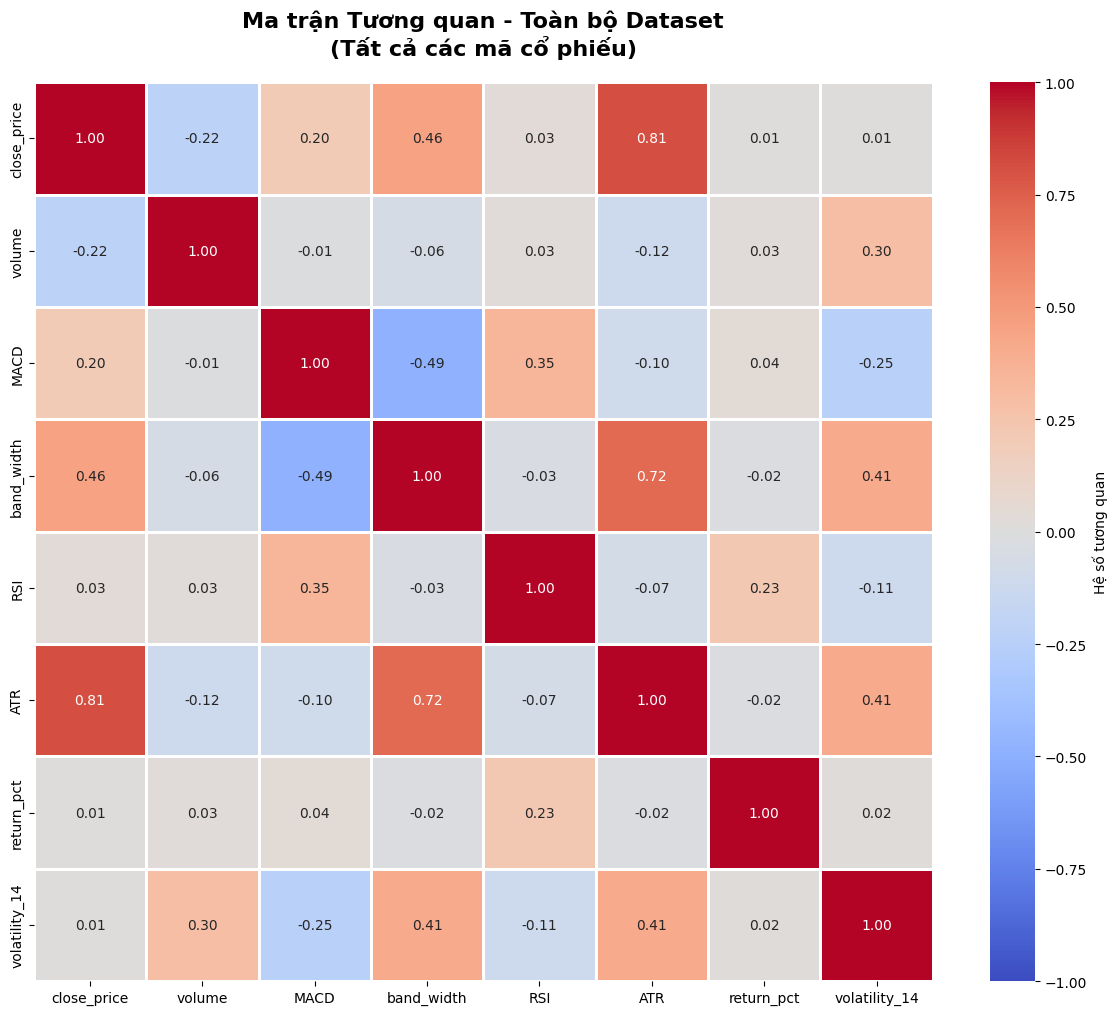

In [3]:
df["band_width"] = df["upper_band"] - df["lower_band"]

cols = [
    "close_price",
    "volume",
    "MACD",
    "band_width",
    "RSI",
    "ATR",
    "return_pct",
    "volatility_14"
]

# Lọc và loại bỏ missing values
plot_df = df[cols].dropna()

# Tính ma trận tương quan
corr_matrix = plot_df.corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,           # Hiển thị số
    fmt=".2f",           
    cmap="coolwarm",    
    center=0,            # Căn giữa tại 0
    square=True,         # Ô vuông
    linewidths=1,        # Đường kẻ
    cbar_kws={'label': 'Hệ số tương quan'},
    vmin=-1, vmax=1
)

plt.title('Ma trận Tương quan - Toàn bộ Dataset\n(Tất cả các mã cổ phiếu)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Heatmap tương quan giữa các return của các cổ phiếu

/tmp/ipykernel_267/1363736303.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns_pivot = returns_pivot.fillna(method='ffill').fillna(method='bfill')


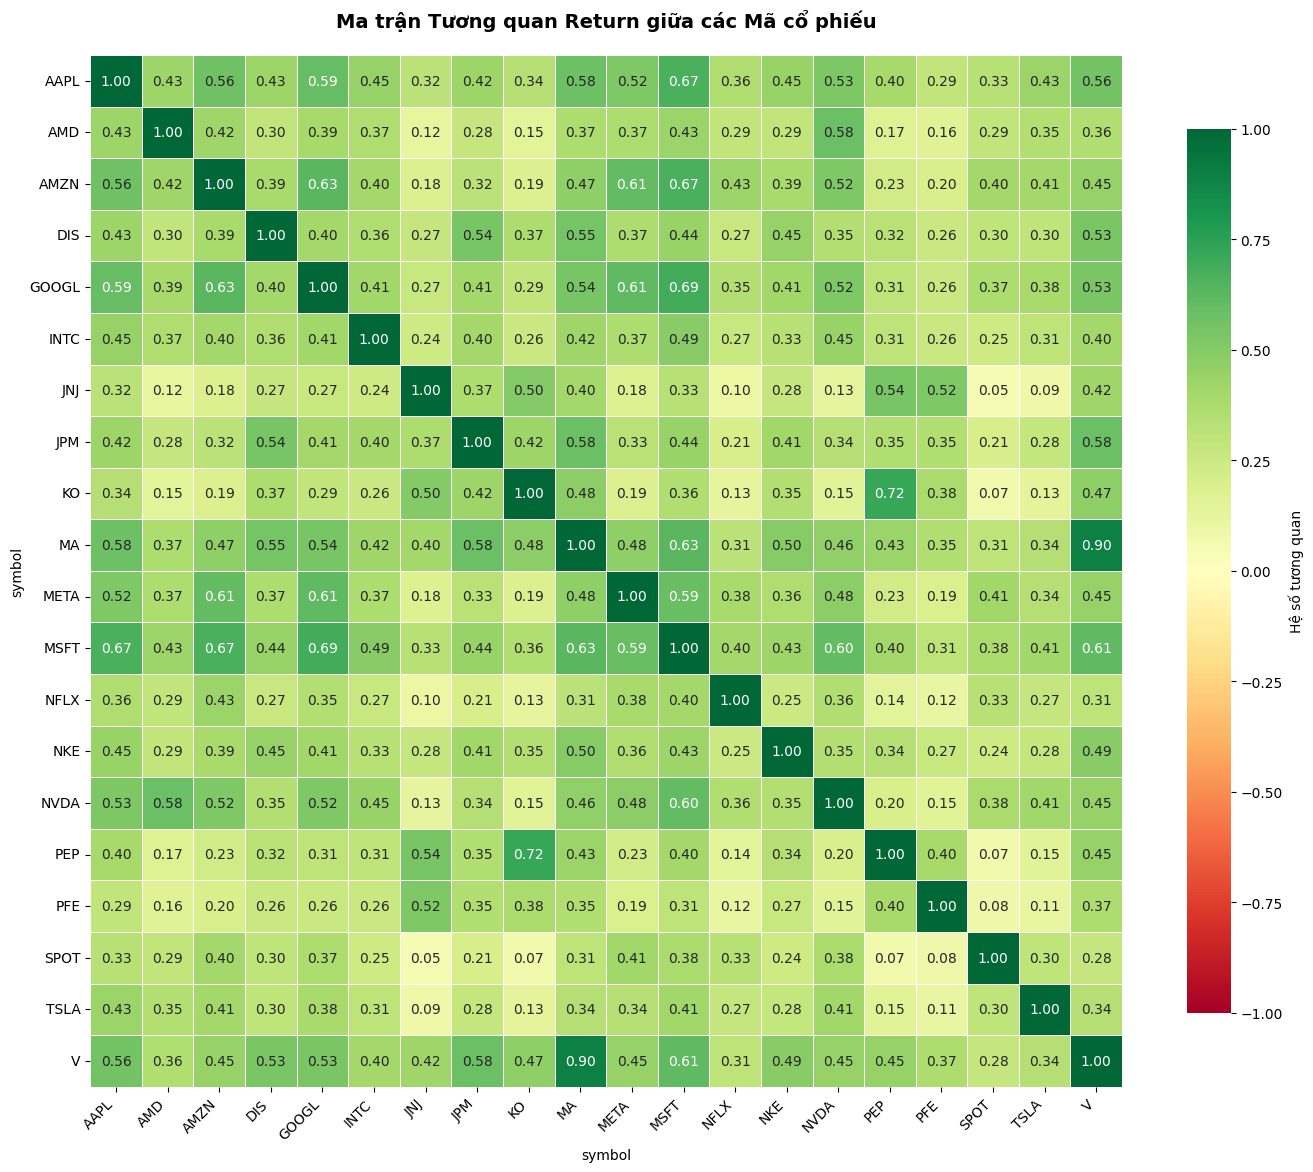

In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['symbol', 'date'])
# Tạo bảng pivot với date làm index, symbol làm columns, return_pct làm values
returns_pivot = df.pivot(index='date', columns='symbol', values='return_pct')

returns_pivot = returns_pivot.fillna(method='ffill').fillna(method='bfill')

correlation_matrix = returns_pivot.corr()

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(correlation_matrix, 
            annot=True,           # Hiển thị số
            fmt='.2f',            # Format 2 chữ số thập phân
            cmap='RdYlGn',        # Màu: đỏ (âm) -> vàng (0) -> xanh (dương)
            center=0,             # Căn giữa tại 0
            square=True,          # Ô vuông
            linewidths=0.5,       # Đường kẻ giữa các ô
            cbar_kws={'label': 'Hệ số tương quan', 'shrink': 0.8},
            vmin=-1, vmax=1,      # Giới hạn từ -1 đến 1
            ax=ax)

ax.set_title('Ma trận Tương quan Return giữa các Mã cổ phiếu', 
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_267/2796265094.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

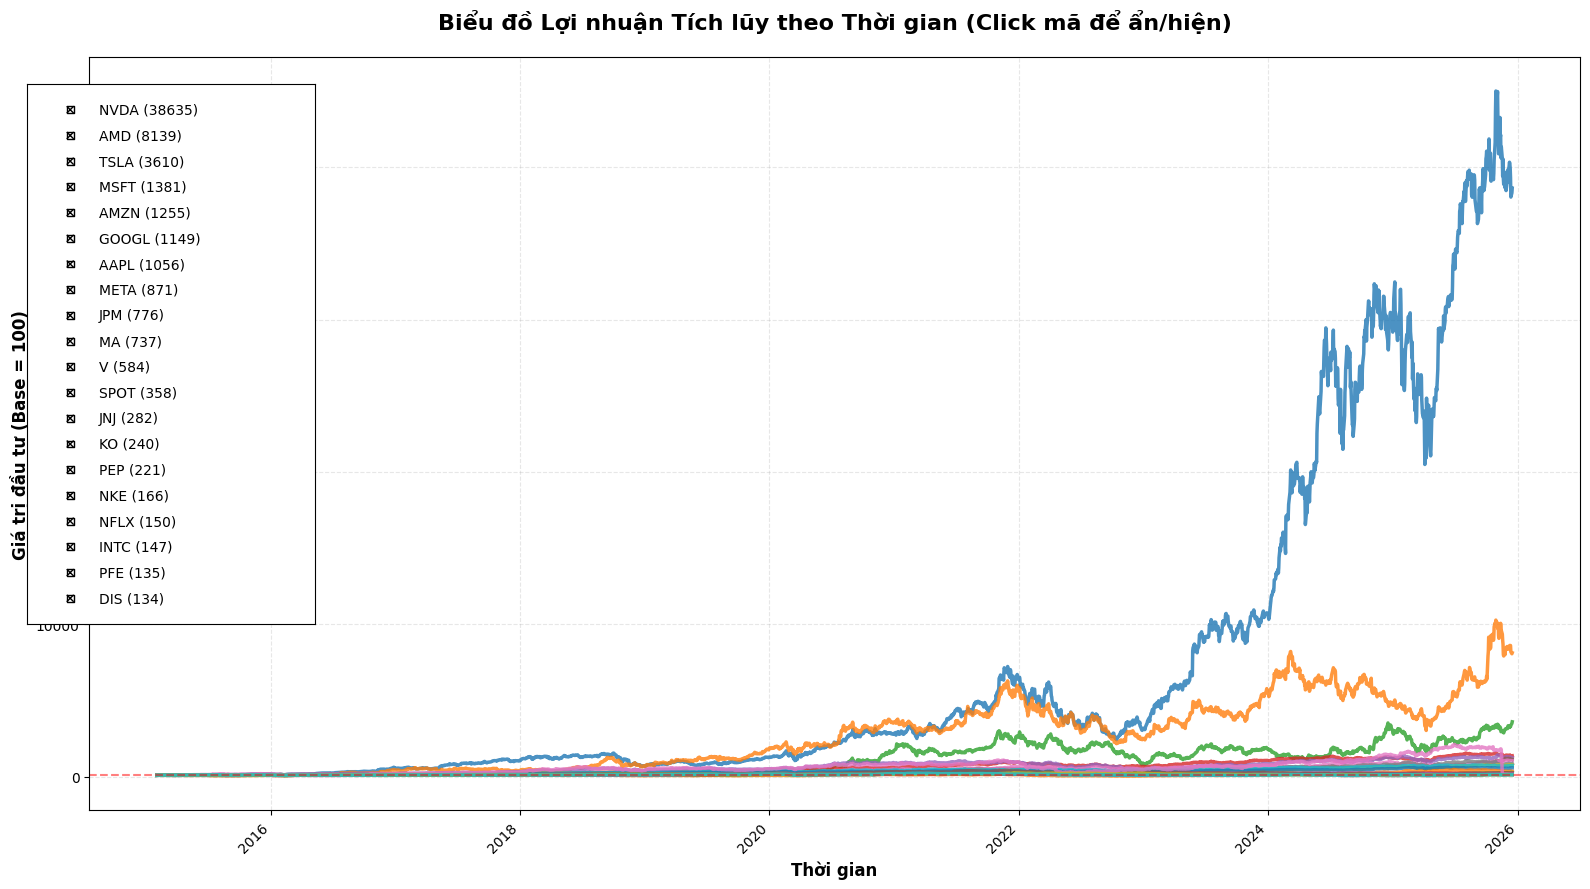

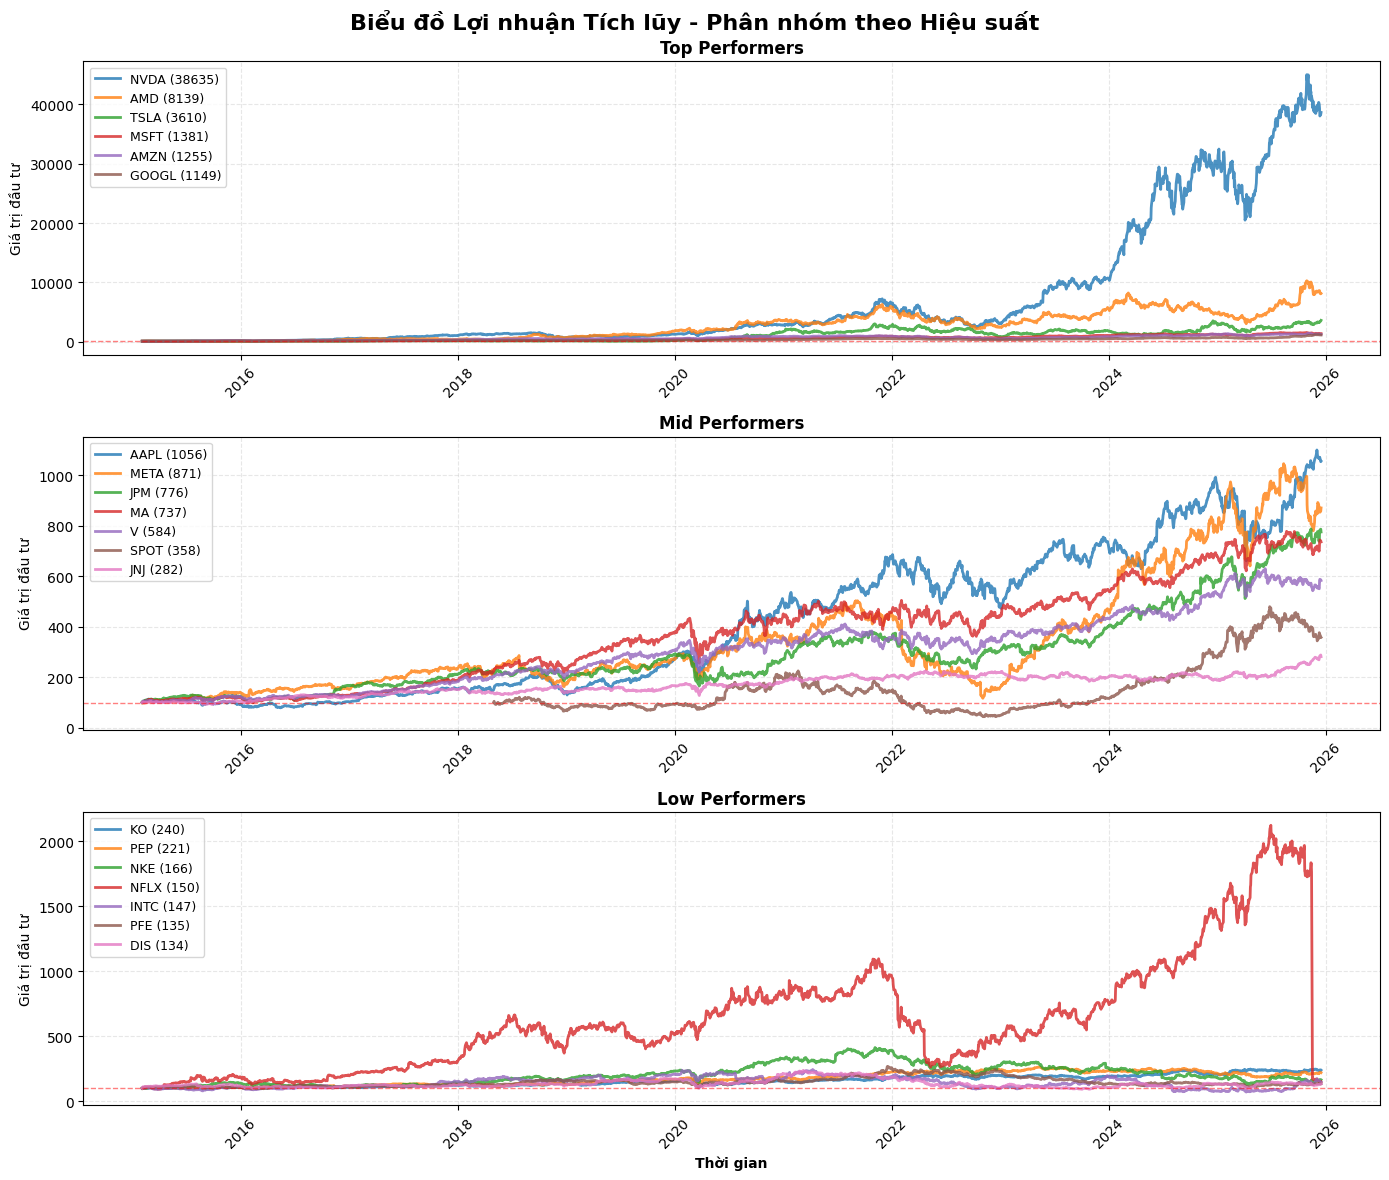

In [5]:
from matplotlib.widgets import CheckButtons

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['symbol', 'date'])

plt.figure(figsize=(14, 8))

symbols = df['symbol'].unique()

cum_returns = {}
final_returns = {}

for symbol in symbols:
    symbol_data = df[df['symbol'] == symbol].copy()
    symbol_data['cumulative_return'] = (1 + symbol_data['return_pct'] / 100).cumprod() * 100
    cum_returns[symbol] = symbol_data
    final_returns[symbol] = symbol_data['cumulative_return'].iloc[-1]

# Sắp xếp symbol theo hiệu suất (cao nhất đến thấp nhất)
sorted_symbols = sorted(symbols, key=lambda x: final_returns[x], reverse=True)

# ============================================================
# PHƯƠNG ÁN 1: BIỂU ĐỒ TƯƠNG TÁC VỚI CHECKBOX
# ============================================================

fig, ax = plt.subplots(figsize=(16, 9))
plt.subplots_adjust(left=0.25)

# Vẽ tất cả các đường và lưu lại reference
lines = {}
for symbol in sorted_symbols:
    symbol_data = cum_returns[symbol]
    line, = ax.plot(symbol_data['date'], 
                    symbol_data['cumulative_return'], 
                    label=f"{symbol} ({final_returns[symbol]:.0f})", 
                    linewidth=2.5,
                    alpha=0.8)
    lines[symbol] = line

ax.set_title('Biểu đồ Lợi nhuận Tích lũy theo Thời gian (Click mã để ẩn/hiện)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Thời gian', fontsize=12, fontweight='bold')
ax.set_ylabel('Giá trị đầu tư (Base = 100)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
plt.xticks(rotation=45, ha='right')

# Tạo checkbox để toggle từng đường
rax = plt.axes([0.02, 0.3, 0.18, 0.6])
labels = [f"{s} ({final_returns[s]:.0f})" for s in sorted_symbols]
visibility = [True] * len(sorted_symbols)
check = CheckButtons(rax, labels, visibility)

def toggle_line(label):
    symbol = label.split(' ')[0]  # Lấy symbol từ label
    lines[symbol].set_visible(not lines[symbol].get_visible())
    plt.draw()

check.on_clicked(toggle_line)

plt.tight_layout()
plt.show()


# Chia thành 3 nhóm: Top performers, Mid performers, Low performers
n = len(sorted_symbols)
top_symbols = sorted_symbols[:n//3]
mid_symbols = sorted_symbols[n//3:2*n//3]
low_symbols = sorted_symbols[2*n//3:]

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Biểu đồ Lợi nhuận Tích lũy - Phân nhóm theo Hiệu suất', 
             fontsize=16, fontweight='bold')

groups = [
    (top_symbols, 'Top Performers', 'green', axes[0]),
    (mid_symbols, 'Mid Performers', 'blue', axes[1]),
    (low_symbols, 'Low Performers', 'orange', axes[2])
]

for group_symbols, title, base_color, ax in groups:
    for symbol in group_symbols:
        symbol_data = cum_returns[symbol]
        ax.plot(symbol_data['date'], 
                symbol_data['cumulative_return'], 
                label=f"{symbol} ({final_returns[symbol]:.0f})", 
                linewidth=2,
                alpha=0.8)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Giá trị đầu tư', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax.legend(loc='upper left', fontsize=9)
    ax.tick_params(axis='x', rotation=45)

axes[2].set_xlabel('Thời gian', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()




Biểu đồ này dùng để so sánh hiệu suất đầu tư giữa các mã. Nó cho thấy sức mạnh khủng khiếp của việc chọn đúng cổ phiếu công nghệ dẫn đầu (trong trường hợp này là NVIDIA) so với phần còn lại của thị trường trong thập kỷ qua.

Giá trị đầu tư (Base = 100): Đây là phần quan trọng nhất. Con số này đại diện cho số tiền bạn có sau một thời gian nếu ban đầu bạn bỏ ra 100 đơn vị tiền tệ (ví dụ: 100 USD).


Đây là nhóm có mức tăng trưởng "không tưởng", làm lu mờ tất cả các nhóm còn lại.

NVDA (NVIDIA): Là cổ phiếu dẫn đầu tuyệt đối với giá trị tích lũy đạt 37,862. Điều này có nghĩa là khoản đầu tư ban đầu đã tăng gấp gần 379 lần.
AMD: Đứng thứ hai nhưng khoảng cách rất xa so với NVIDIA, đạt mức 8,801 (tăng gấp 88 lần).
Đặc điểm chung: Các mã công nghệ (bán dẫn, xe điện như TSLA) chiếm ưu thế, với sự bứt phá mạnh mẽ nhất bắt đầu từ giai đoạn 2023–2024 (làn sóng AI).


Nhóm Hiệu suất Trung bình (Mid Performers)
Nhóm này bao gồm các "ông lớn" công nghệ và tài chính có mức tăng trưởng ổn định và rất tốt so với thị trường chung.
- AAPL (Apple) và META: Dẫn đầu nhóm này với giá trị quanh mức 1,000. Nghĩa là sau 10 năm, nhà đầu tư nhân khoảng 10 lần tài sản.
- Biến động: Nhóm này chịu ảnh hưởng rõ rệt bởi đợt sụt giảm chung của thị trường vào năm 2022 nhưng đã phục hồi mạnh mẽ ngay sau đó.


Nhóm Hiệu suất Thấp (Low Performers): Nhóm này chủ yếu là các cổ phiếu ngành hàng tiêu dùng thiết yếu (KO, PEP), y tế (PFE, JNJ) và các công nghệ cũ đang gặp khó khăn (INTC).
- Hiệu suất: Giá trị tích lũy chỉ dao động từ 130 đến 250. Mức lợi nhuận này (tăng 1.3 đến 2.5 lần sau 10 năm) là khá thấp khi so với tốc độ tăng trưởng của ngành công nghệ.


In [6]:
aapl = df[df["symbol"] == "AAPL"].head(10)
print(aapl[['date', 'close_price', 'return_pct']])

        date  close_price  return_pct
0 2015-01-02    24.237551   -0.951269
1 2015-01-05    23.554737   -2.817173
2 2015-01-06    23.556959    0.009434
3 2015-01-07    23.887278    1.402212
4 2015-01-08    24.805082    3.842232
5 2015-01-09    24.831684    0.107243
6 2015-01-12    24.219814   -2.464069
7 2015-01-13    24.434860    0.887893
8 2015-01-14    24.341747   -0.381066
9 2015-01-15    23.681103   -2.714039


In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['symbol', 'date'])
# Tạo bảng pivot với date làm index, symbol làm columns, return_pct làm values
returns_pivot = df.pivot(index='date', columns='symbol', values='return_pct')


returns_pivot = returns_pivot.fillna(method='ffill').fillna(method='bfill')

print("Kích thước dữ liệu:", returns_pivot.shape)
print("\nMẫu dữ liệu return_pct:")
print(returns_pivot.head())

Kích thước dữ liệu: (2719, 18)

Mẫu dữ liệu return_pct:
symbol          AAPL       AMD      AMZN       DIS     GOOGL      INTC  \
date                                                                     
2015-01-02 -0.951269  0.000000 -0.589659 -0.467164 -0.209176  0.192840   
2015-01-05 -2.817173 -0.374531 -2.051729 -1.461323 -1.905395 -1.127626   
2015-01-06  0.009434 -1.127818 -2.283333 -0.530424 -2.467936 -1.863680   
2015-01-07  1.402212 -1.901148  1.059974  1.022969 -0.294110  2.097503   
2015-01-08  3.842232  1.162790  0.683602  1.034144  0.348424  1.860092   

symbol           JNJ       JPM        KO        MA      META      MSFT  \
date                                                                     
2015-01-02 -0.047842  0.498529 -0.189487 -0.557109  0.551134  0.667390   
2015-01-05 -0.698413 -3.104491  0.000000 -2.812781 -1.606120 -0.919582   
2015-01-06 -0.491390 -2.592913  0.759369 -0.216184 -1.347328 -1.467751   
2015-01-07  2.207593  0.152599  1.248213  1.555555  0.0

/tmp/ipykernel_5476/260822887.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns_pivot = returns_pivot.fillna(method='ffill').fillna(method='bfill')


In [8]:
correlation_matrix = returns_pivot.corr()

print("\n" + "="*70)
print("MA TRẬN TƯƠNG QUAN RETURN_PCT")
print("="*70)
print(correlation_matrix.round(3))


MA TRẬN TƯƠNG QUAN RETURN_PCT
symbol   AAPL    AMD   AMZN    DIS  GOOGL   INTC    JNJ    JPM     KO     MA  \
symbol                                                                         
AAPL    1.000  0.424  0.559  0.427  0.594  0.453  0.319  0.426  0.343  0.578   
AMD     0.424  1.000  0.413  0.296  0.394  0.366  0.130  0.278  0.150  0.374   
AMZN    0.559  0.413  1.000  0.384  0.639  0.394  0.186  0.316  0.187  0.477   
DIS     0.427  0.296  0.384  1.000  0.407  0.367  0.278  0.545  0.370  0.555   
GOOGL   0.594  0.394  0.639  0.407  1.000  0.413  0.273  0.409  0.298  0.549   
INTC    0.453  0.366  0.394  0.367  0.413  1.000  0.253  0.406  0.268  0.423   
JNJ     0.319  0.130  0.186  0.278  0.273  0.253  1.000  0.373  0.507  0.400   
JPM     0.426  0.278  0.316  0.545  0.409  0.406  0.373  1.000  0.426  0.582   
KO      0.343  0.150  0.187  0.370  0.298  0.268  0.507  0.426  1.000  0.485   
MA      0.578  0.374  0.477  0.555  0.549  0.423  0.400  0.582  0.485  1.000   
META    0

In [9]:
# fig, ax = plt.subplots(figsize=(14, 12))

# sns.heatmap(correlation_matrix, 
#             annot=True,           # Hiển thị số
#             fmt='.2f',            # Format 2 chữ số thập phân
#             cmap='RdYlGn',        # Màu: đỏ (âm) -> vàng (0) -> xanh (dương)
#             center=0,             # Căn giữa tại 0
#             square=True,          # Ô vuông
#             linewidths=0.5,       # Đường kẻ giữa các ô
#             cbar_kws={'label': 'Hệ số tương quan', 'shrink': 0.8},
#             vmin=-1, vmax=1,      # Giới hạn từ -1 đến 1
#             ax=ax)

# ax.set_title('Ma trận Tương quan Return giữa các Mã cổ phiếu', 
#              fontsize=14, fontweight='bold', pad=20)

# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [10]:
symbols = df['symbol'].unique()
risk_return_data = []

for symbol in symbols:
    symbol_data = df[df['symbol'] == symbol].copy()
    
    # Lấy trực tiếp từ data có sẵn
    avg_return = symbol_data['return_pct'].mean()
    avg_volatility = symbol_data['volatility_14'].mean()
    
    # Tính Sharpe Ratio (giả định risk-free rate = 0)
    sharpe_ratio = avg_return / avg_volatility if avg_volatility > 0 else 0
    
    # Tính tổng lợi nhuận tích lũy
    total_return = ((1 + symbol_data['return_pct'] / 100).prod() - 1) * 100
    
    # Tính số ngày giao dịch
    trading_days = len(symbol_data)
    
    risk_return_data.append({
        'symbol': symbol,
        'avg_return': avg_return,
        'avg_volatility': avg_volatility,
        'sharpe_ratio': sharpe_ratio,
        'total_return': total_return,
        'trading_days': trading_days
    })

risk_return_df = pd.DataFrame(risk_return_data)

# Sắp xếp theo Sharpe Ratio
risk_return_df = risk_return_df.sort_values('sharpe_ratio', ascending=False)

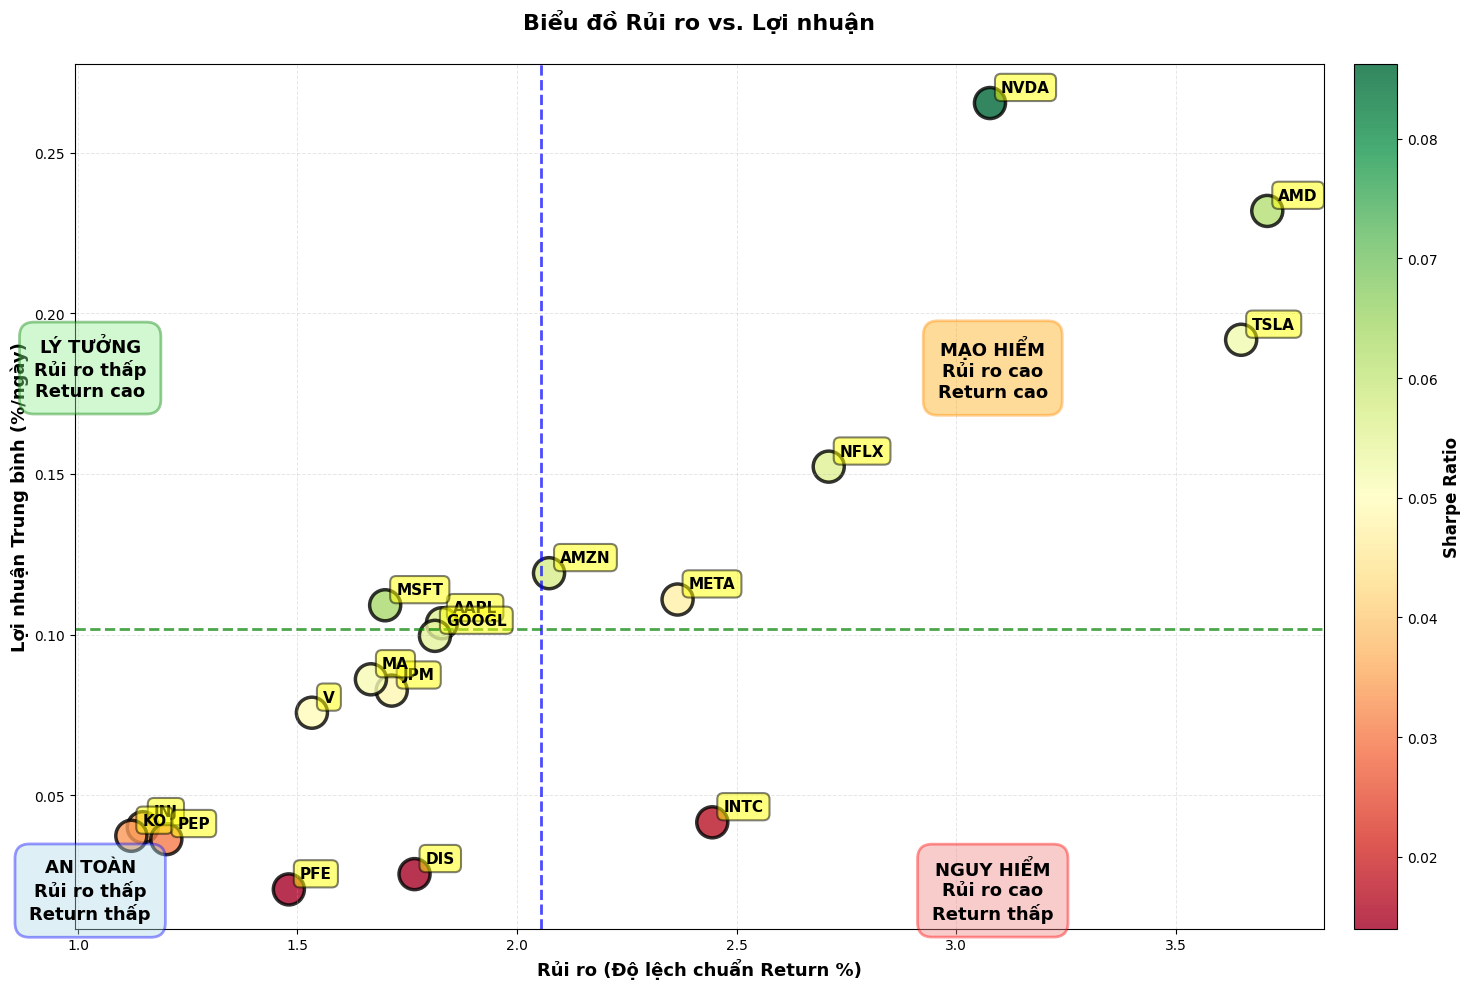

In [11]:
risk_return_summary = df.groupby('symbol').agg({
    'return_pct': ['mean', 'std'],
    'volatility_14': 'mean'
}).reset_index()

risk_return_summary.columns = ['symbol', 'avg_return', 'std_return', 'avg_volatility']
risk_return_summary['sharpe_ratio'] = risk_return_summary['avg_return'] / risk_return_summary['std_return']

# Tính giá trị trung bình để chia 4 vùng
avg_return = risk_return_summary['avg_return'].mean()
avg_risk = risk_return_summary['std_return'].mean()

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(
    risk_return_summary['std_return'],
    risk_return_summary['avg_return'],
    s=500,
    c=risk_return_summary['sharpe_ratio'],
    cmap='RdYlGn',
    alpha=0.8,
    edgecolors='black',
    linewidth=2.5
)

# Thêm tên mã
for idx, row in risk_return_summary.iterrows():
    ax.annotate(
        row['symbol'], 
        (row['std_return'], row['avg_return']),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.5, edgecolor='black', linewidth=1.5)
    )

# Vẽ đường chia 4 vùng
ax.axvline(x=avg_risk, color='blue', linestyle='--', alpha=0.7, linewidth=2)
ax.axhline(y=avg_return, color='green', linestyle='--', alpha=0.7, linewidth=2)

# Đánh dấu 4 vùng
x_left = avg_risk * 0.5
x_right = avg_risk * 1.5
y_top = avg_return * 1.8
y_bottom = avg_return * 0.2

ax.text(x_left, y_top, 'LÝ TƯỞNG\nRủi ro thấp\nReturn cao', 
        fontsize=13, ha='center', va='center', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', alpha=0.4, edgecolor='green', linewidth=2))

ax.text(x_right, y_top, 'MẠO HIỂM\nRủi ro cao\nReturn cao', 
        fontsize=13, ha='center', va='center', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='orange', alpha=0.4, edgecolor='darkorange', linewidth=2))

ax.text(x_left, y_bottom, 'AN TOÀN\nRủi ro thấp\nReturn thấp', 
        fontsize=13, ha='center', va='center', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.4, edgecolor='blue', linewidth=2))

ax.text(x_right, y_bottom, 'NGUY HIỂM\nRủi ro cao\nReturn thấp', 
        fontsize=13, ha='center', va='center', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightcoral', alpha=0.4, edgecolor='red', linewidth=2))

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Sharpe Ratio', fontsize=12, fontweight='bold')

# Tiêu đề và nhãn
ax.set_title('Biểu đồ Rủi ro vs. Lợi nhuận', fontsize=16, fontweight='bold', pad=25)
ax.set_xlabel('Rủi ro (Độ lệch chuẩn Return %)', fontsize=13, fontweight='bold')
ax.set_ylabel('Lợi nhuận Trung bình (%/ngày)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

Biểu đồ này chia các cổ phiếu thành 4 vùng dựa trên Rủi ro (Độ lệch chuẩn) và Lợi nhuận trung bình hàng ngày:

Vùng Mạo hiểm (Lợi nhuận cao - Rủi ro cao):

NVDA, AMD, TSLA: Đây là những "quái vật" tăng trưởng. NVDA đứng ở vị trí cao nhất về lợi nhuận và có màu xanh đậm nhất (chỉ số Sharpe Ratio cực tốt), nghĩa là lợi nhuận thu về rất xứng đáng với rủi ro bỏ ra.

TSLA và AMD có rủi ro (độ biến động) rất lớn, nằm xa nhất về phía bên phải trục hoành. Điều này giải thích tại sao ở biểu đồ hiệu suất, các mã này có những cú "rơi" rất sâu trước khi bật tăng lại.

Vùng Lý tưởng (Lợi nhuận cao - Rủi ro thấp):

MSFT, AAPL, GOOGL: Các mã này nằm gần trục tung hơn, cho thấy sự ổn định cao hơn nhóm chip nhưng vẫn duy trì mức lợi nhuận tốt. Đặc biệt, MSFT có màu xanh khá tươi, cho thấy hiệu suất điều chỉnh theo rủi ro rất hiệu quả.

Vùng An toàn (Lợi nhuận thấp - Rủi ro thấp):

KO, PEP, JNJ: Các mã tiêu dùng và y tế này cụm lại ở góc dưới bên trái. Rủi ro rất thấp nhưng lợi nhuận cũng khiêm tốn, phù hợp để giữ vốn hơn là làm giàu nhanh.

Vùng Nguy hiểm (Lợi nhuận thấp - Rủi ro cao):

INTC, DIS, PFE: Đây là những mã gây thất vọng nhất. Chúng có độ biến động (rủi ro) tương đương hoặc cao hơn nhóm an toàn nhưng lợi nhuận lại thấp hơn đáng kể. INTC có màu đỏ đậm, cho thấy chỉ số Sharpe rất thấp—nhà đầu tư đang chịu rủi ro cao mà không nhận lại được bao nhiêu lợi nhuận.

2. Mối liên hệ với Ma trận Tương quan
Đa dạng hóa: Nếu bạn kết hợp NVDA (Mạo hiểm) với KO hoặc JNJ (An toàn), bạn sẽ có một danh mục cân bằng vì tương quan giữa chúng rất thấp (khoảng 0.13 - 0.16).

Rủi ro hệ thống: Các mã trong nhóm "Mid Performers" như MA và V có tương quan cực cao (0.90), do đó chúng nằm ở vị trí gần như đè lên nhau trên biểu đồ rủi ro.

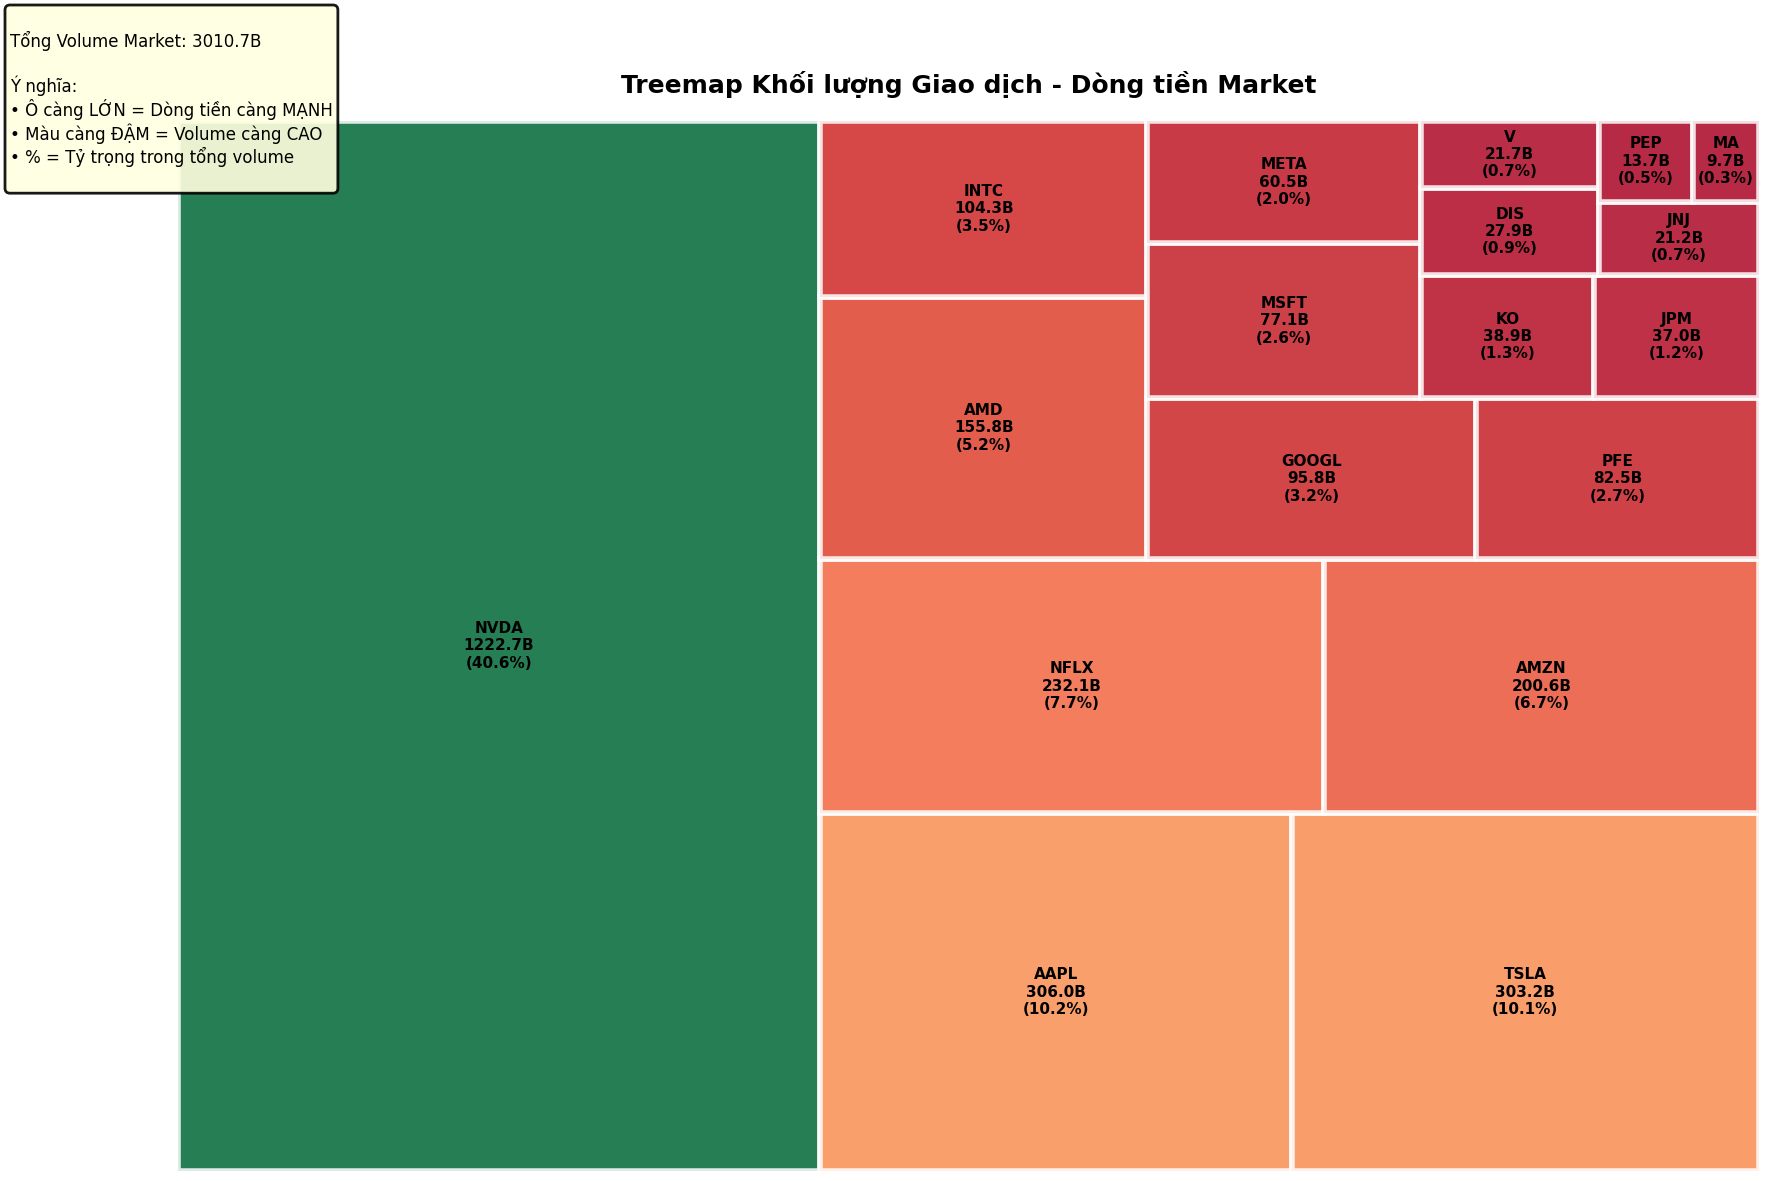

In [12]:
import squarify

volume_summary = df.groupby('symbol')['volume'].sum().reset_index()
volume_summary.columns = ['symbol', 'total_volume']
volume_summary = volume_summary.sort_values('total_volume', ascending=False)

# Tính % volume so với tổng
total_market_volume = volume_summary['total_volume'].sum()
volume_summary['volume_pct'] = (volume_summary['total_volume'] / total_market_volume * 100)

# Chuẩn bị dữ liệu cho treemap
sizes = volume_summary['total_volume']
labels = [f"{row['symbol']}\n{row['total_volume']/1e9:.1f}B\n({row['volume_pct']:.1f}%)" 
          for _, row in volume_summary.iterrows()]

# Tạo màu gradient: Volume càng cao, màu càng xanh
normalized_volumes = volume_summary['total_volume'] / volume_summary['total_volume'].max()
cmap = plt.cm.RdYlGn  # Đỏ (thấp) -> Vàng -> Xanh (cao)
colors = [cmap(v) for v in normalized_volumes]

# Vẽ treemap
fig, ax = plt.subplots(figsize=(18, 12))

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.85,
    text_kwargs={'fontsize': 11, 'weight': 'bold', 'color': 'black'},
    edgecolor='white',
    linewidth=4,
    ax=ax
)

ax.set_title('Treemap Khối lượng Giao dịch - Dòng tiền Market', 
             fontsize=18, fontweight='bold', pad=20)
ax.axis('off')

# Thêm chú thích
legend_text = f"""
Tổng Volume Market: {total_market_volume/1e9:.1f}B

Ý nghĩa:
• Ô càng LỚN = Dòng tiền càng MẠNH
• Màu càng ĐẬM = Volume càng CAO
• % = Tỷ trọng trong tổng volume
"""
ax.text(0.02, 0.98, legend_text,
        transform=fig.transFigure,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

For each Symbol

/tmp/ipykernel_5476/926505525.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=sorted(aapl["year"].unique()))


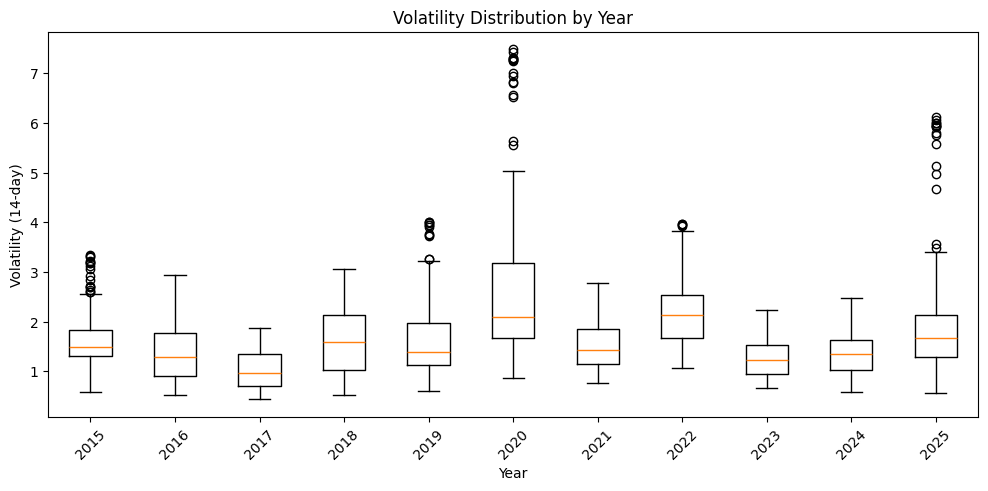

In [13]:
aapl = df[df["symbol"] == "AAPL"].copy()


# Tạo biến
aapl["date"] = pd.to_datetime(aapl["date"])
aapl["year"] = aapl["date"].dt.year
aapl["month"] = aapl["date"].dt.month

data_box = [
    aapl[aapl["year"] == y]["volatility_14"].dropna()
    for y in sorted(aapl["year"].unique())
]

plt.figure(figsize=(12,5))
plt.boxplot(data_box, labels=sorted(aapl["year"].unique()))
plt.title("Volatility Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Volatility (14-day)")
plt.xticks(rotation=45)
plt.show()



Cách đọc boxplot for dummy
Biểu đồ thể hiện phân bố độ biến động giá 14 ngày (volatility_14) của cổ phiếu AAPL theo từng năm.

#### Mỗi box = 1 năm
#### Dữ liệu trong box = tất cả giá trị volatility_14 của năm đó
Thành phần:
- Đường ngang ở giữa box (Median):Là giá trị volatility_14 trung vị của năm cho biết mức biến động “điển hình” trong năm đó Median cao hơn → năm đó thị trường biến động mạnh hơn
- Cạnh dưới & trên của box (Q1 – Q3): Q1 (25%): 25% dữ liệu thấp nhất, Q3 (75%): 75% dữ liệu thấp hơn mức này.
- Chiều cao box (IQR = Q3 − Q1):Phản ánh mức độ phân tán / ổn định, Box cao → biến động thất thường, Box thấp → biến động ổn định
- Các điểm bên ngoài:(Outliers): Đại diện cho Những giai đoạn thị trường biến động đột biến

Box plot giúp bạn trả lời nhanh 3 câu hỏi quan trọng:
Năm nào biến động mạnh nhất?: Nhìn median cao + box cao
Năm nào ổn định nhất?: → Median thấp + box thấp
Năm nào có nhiều cú sốc thị trường?: → Nhiều outliers / râu dài

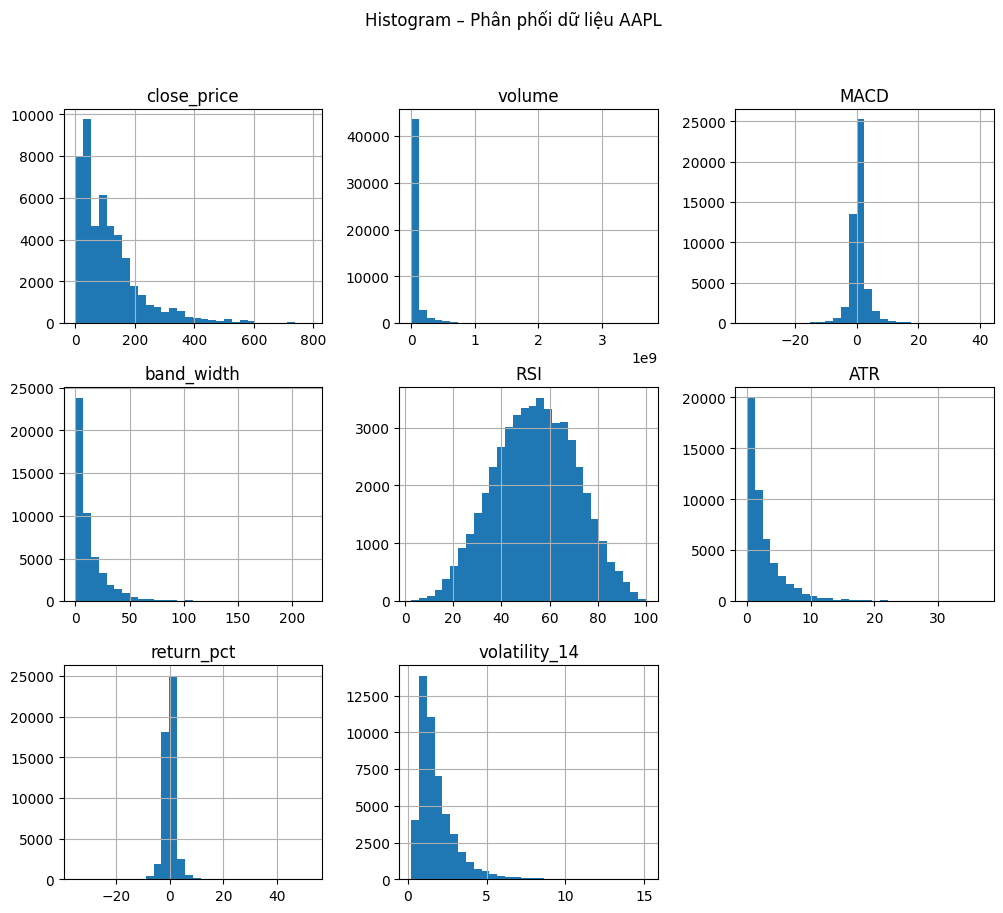

In [14]:
plot_df.hist(figsize=(12,10), bins=30)
plt.suptitle("Histogram – Phân phối dữ liệu AAPL")
plt.show()

Chart cho từng Symbol

Chọn AAPL làm mẫu

In [15]:
symbol = "AAPL" 
aapl = df[df["symbol"] == symbol].copy()
aapl = aapl.sort_values('date')

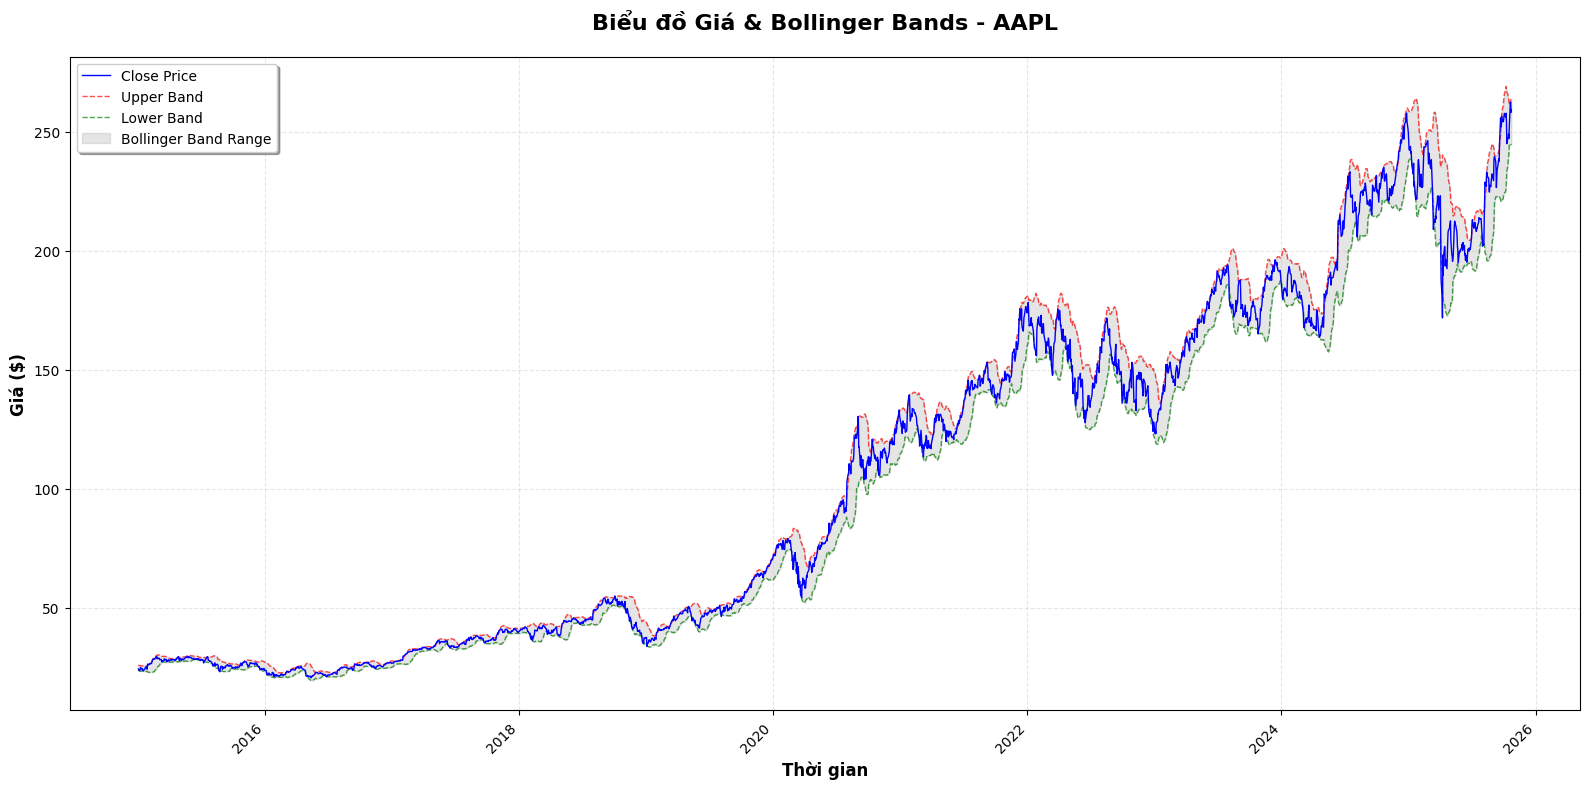

In [20]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(16, 8))

# Vẽ đường close_price
ax.plot(aapl['date'], aapl['close_price'], 
        color='blue', linewidth=1, label='Close Price', zorder=3)

# Vẽ upper_band và lower_band
ax.plot(aapl['date'], aapl['upper_band'], 
        color='red', linewidth=1, linestyle='--', label='Upper Band', alpha=0.7, zorder=2)
ax.plot(aapl['date'], aapl['lower_band'], 
        color='green', linewidth=1, linestyle='--', label='Lower Band', alpha=0.7, zorder=2)

# Tô màu vùng giữa upper_band và lower_band
ax.fill_between(aapl['date'], aapl['upper_band'], aapl['lower_band'], 
                color='gray', alpha=0.2, label='Bollinger Band Range', zorder=1)

# # Đánh dấu vùng quá mua (giá chạm upper_band)
# overbought = aapl[aapl['close_price'] >= aapl['upper_band']]
# ax.scatter(overbought['date'], overbought['close_price'], 
#            color='red', s=50, marker='v', label='Quá mua (Overbought)', zorder=4)

# # Đánh dấu vùng quá bán (giá chạm lower_band)
# oversold = aapl[aapl['close_price'] <= aapl['lower_band']]
# ax.scatter(oversold['date'], oversold['close_price'], 
#            color='green', s=50, marker='^', label='Quá bán (Oversold)', zorder=4)

# Tùy chỉnh biểu đồ
ax.set_title(f'Biểu đồ Giá & Bollinger Bands - {symbol}', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Thời gian', fontsize=12, fontweight='bold')
ax.set_ylabel('Giá ($)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=10, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

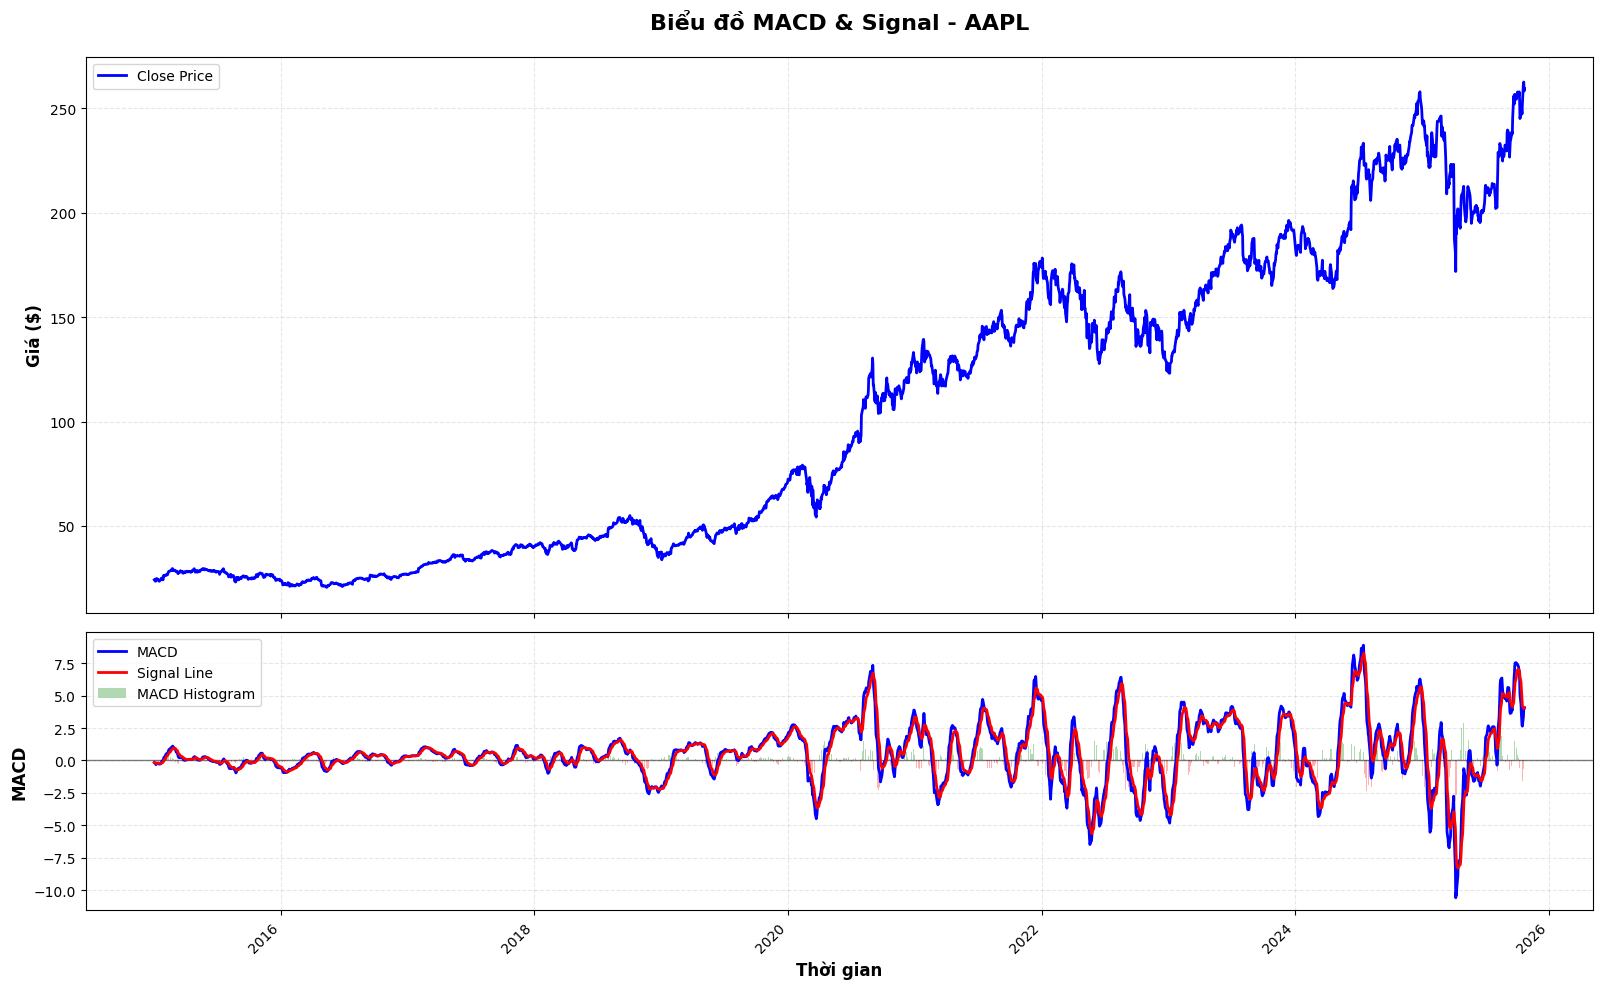

In [17]:
if 'signal' not in aapl.columns:
    aapl['signal'] = aapl['MACD'].ewm(span=9, adjust=False).mean()

# Tính MACD Histogram
aapl['macd_histogram'] = aapl['MACD'] - aapl['signal']

# Vẽ biểu đồ với 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                gridspec_kw={'height_ratios': [2, 1]}, 
                                sharex=True)

# ============ Subplot 1: Giá ============
ax1.plot(aapl['date'], aapl['close_price'], 
         color='blue', linewidth=2, label='Close Price')
ax1.set_ylabel('Giá ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'Biểu đồ MACD & Signal - {symbol}', 
              fontsize=16, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# ============ Subplot 2: MACD ============
# Vẽ đường MACD
ax2.plot(aapl['date'], aapl['MACD'], 
         color='blue', linewidth=2, label='MACD', zorder=3)

# Vẽ đường Signal
ax2.plot(aapl['date'], aapl['signal'], 
         color='red', linewidth=2, label='Signal Line', zorder=3)

# Vẽ MACD Histogram (cột)
colors = ['green' if x >= 0 else 'red' for x in aapl['macd_histogram']]
ax2.bar(aapl['date'], aapl['macd_histogram'], 
        color=colors, alpha=0.3, label='MACD Histogram', zorder=1)

# Đường zero line
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Đánh dấu điểm giao cắt (crossover)
# # Tìm điểm MACD cắt lên Signal (tín hiệu mua)
# aapl['macd_cross_up'] = (aapl['MACD'] > aapl['signal']) & (aapl['MACD'].shift(1) <= aapl['signal'].shift(1))
# cross_up = aapl[aapl['macd_cross_up']]
# ax2.scatter(cross_up['date'], cross_up['MACD'], 
#             color='green', s=100, marker='^', label='Tín hiệu MUA', zorder=4)

# # Tìm điểm MACD cắt xuống Signal (tín hiệu bán)
# aapl['macd_cross_down'] = (aapl['MACD'] < aapl['signal']) & (aapl['MACD'].shift(1) >= aapl['signal'].shift(1))
# cross_down = aapl[aapl['macd_cross_down']]
# ax2.scatter(cross_down['date'], cross_down['MACD'], 
#             color='red', s=100, marker='v', label='Tín hiệu BÁN', zorder=4)

ax2.set_xlabel('Thời gian', fontsize=12, fontweight='bold')
ax2.set_ylabel('MACD', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

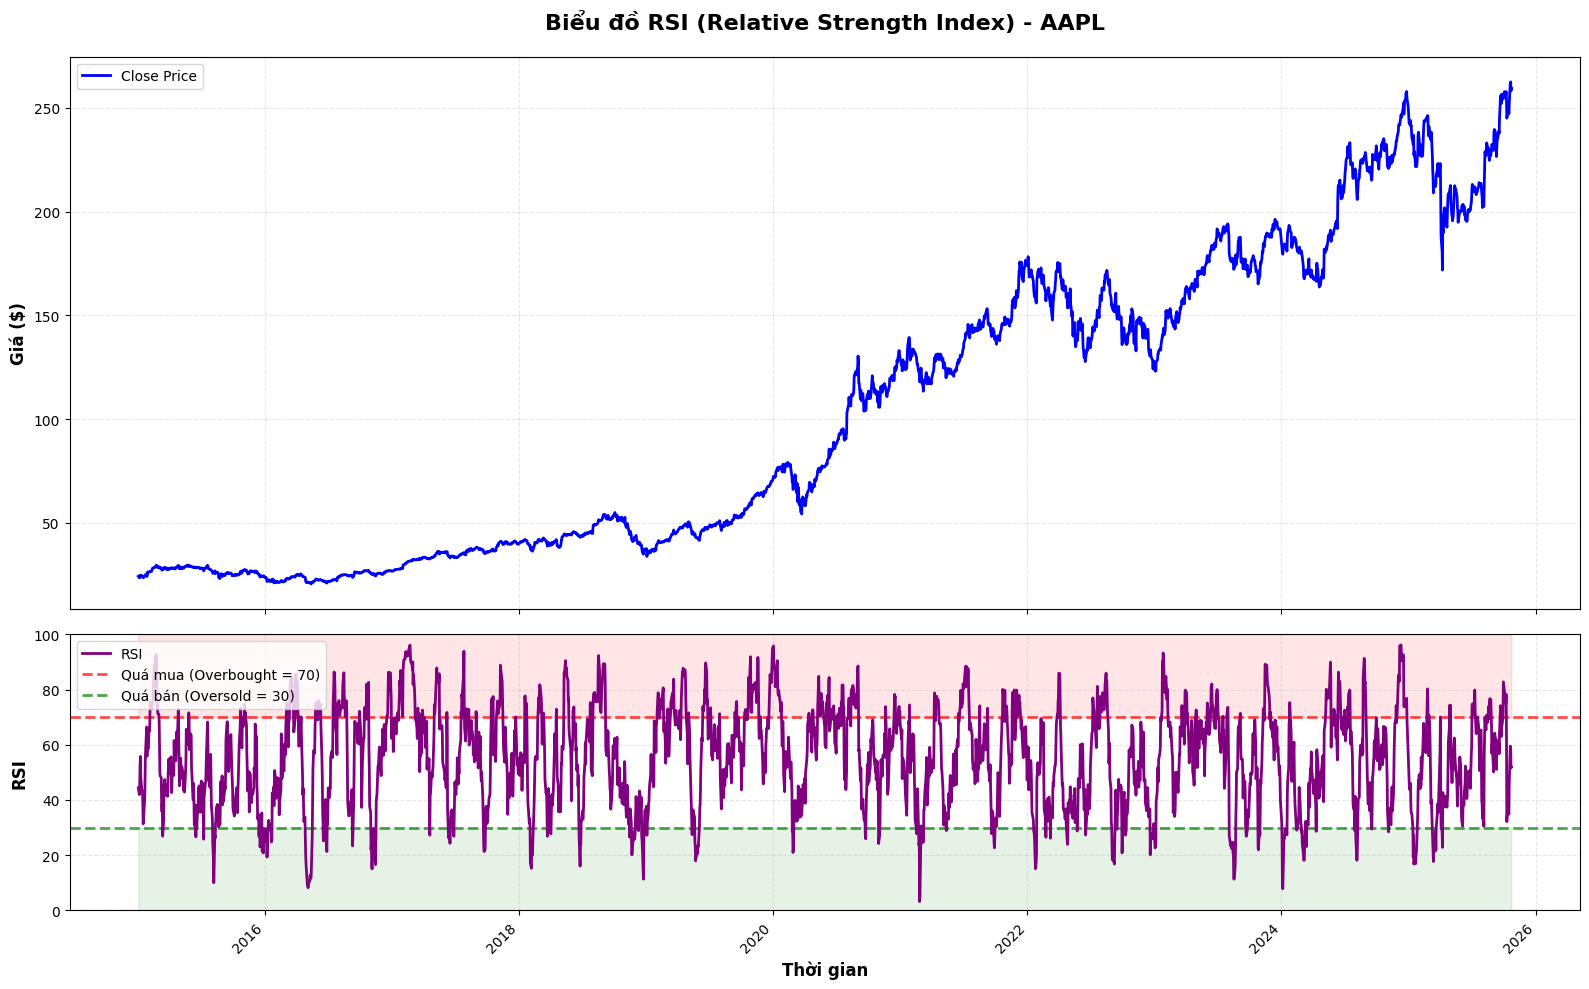

In [18]:
# Vẽ biểu đồ với 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                gridspec_kw={'height_ratios': [2, 1]}, 
                                sharex=True)

# ============ Subplot 1: Giá ============
ax1.plot(aapl['date'], aapl['close_price'], 
         color='blue', linewidth=2, label='Close Price')
ax1.set_ylabel('Giá ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'Biểu đồ RSI (Relative Strength Index) - {symbol}', 
              fontsize=16, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# ============ Subplot 2: RSI ============
# Vẽ đường RSI
ax2.plot(aapl['date'], aapl['RSI'], 
         color='purple', linewidth=2, label='RSI', zorder=3)

# Vẽ vạch ngưỡng 70 (Quá mua)
ax2.axhline(y=70, color='red', linestyle='--', linewidth=2, 
            label='Quá mua (Overbought = 70)', alpha=0.7)

# Vẽ vạch ngưỡng 30 (Quá bán)
ax2.axhline(y=30, color='green', linestyle='--', linewidth=2, 
            label='Quá bán (Oversold = 30)', alpha=0.7)

# Tô màu vùng quá mua (RSI > 70)
ax2.fill_between(aapl['date'], 70, 100, color='red', alpha=0.1)

# Tô màu vùng quá bán (RSI < 30)
ax2.fill_between(aapl['date'], 0, 30, color='green', alpha=0.1)

# # Đánh dấu điểm quá mua
# overbought = aapl[aapl['RSI'] >= 70]
# ax2.scatter(overbought['date'], overbought['RSI'], 
#             color='red', s=50, marker='o', alpha=0.6, zorder=4)

# # Đánh dấu điểm quá bán
# oversold = aapl[aapl['RSI'] <= 30]
# ax2.scatter(oversold['date'], oversold['RSI'], 
#             color='green', s=50, marker='o', alpha=0.6, zorder=4)

ax2.set_xlabel('Thời gian', fontsize=12, fontweight='bold')
ax2.set_ylabel('RSI', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()